In [38]:
# Create NN model using PyTorch
import torch
from torch import nn

class MLP_MNIST(nn.Module):
    def __init__(self, input_size, h1_size, h2_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(input_size, h1_size)
        self.activation_fn1 = nn.Sigmoid()
        self.layer2 = nn.Linear(h1_size, h2_size)
        self.activation_fn2 = nn.Sigmoid()
        self.layer_out = nn.Linear(h2_size, output_size)
        self.softmax = nn.Softmax(dim=0)

    def flatten_mnist(self, x):
        result = self.flatten(x)[0]
        return result
        
    def forward(self, x):
        x = self.flatten_mnist(x)
        z1 = self.layer1(x)
        a1 = self.activation_fn1(z1)
        z2 = self.layer2(a1)
        a2 = self.activation_fn2(z2)
        z_out = self.layer_out(a2)
        y = self.softmax(z_out)
        return y

model_mnist = MLP_MNIST(784, 100, 100, 10)
print(model_mnist)

MLP_MNIST(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=100, bias=True)
  (activation_fn1): Sigmoid()
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (activation_fn2): Sigmoid()
  (layer_out): Linear(in_features=100, out_features=10, bias=True)
  (softmax): Softmax(dim=0)
)


In [39]:
# Load the MNIST handwritten number dataset by using PyTorch
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

batch_size = 1
# Read the MNIST dataset by using torch and torchvision
# This will download the file to PATH if there's no dataset in the PATH
train_loader = DataLoader(
    MNIST('dataset', train=True, download=True,
          transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    MNIST('dataset', train=False, download=True,
          transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=True
)

# Our label is integer (0-9). So, we need a function to convert it into 1x10 vector
# example 0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# example 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
def label_conversion_for_outputlayer(y):
    if y == 0:
        ret = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    elif y == 1:
        ret = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    elif y == 2:
        ret = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    elif y == 3:
        ret = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    elif y == 4:
        ret = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    elif y == 5:
        ret = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    elif y == 6:
        ret = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
    elif y == 7:
        ret = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
    elif y == 8:
        ret = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
    elif y == 9:
        ret = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    return torch.Tensor(ret)
    

In [46]:
# Training
from torch.optim import SGD

# hyperparameters
learning_rate = 0.01
momentum = 0.01

# Loss function
loss_fn = nn.MSELoss(reduction='mean')
# Stochastic Gradient Descent (SGD) as optimizer in training procedure
# 
# v = momentum * v - lr * grad(w)
# w = w + v
optimizer = SGD(model_mnist.parameters(), lr=learning_rate, momentum=momentum)

num_epochs = 20
# Start iterate for model training
loss_arr = []
for epoch in range(num_epochs):
    for batch_idx, train_data in enumerate(train_loader):
        x_batch, y_batch = train_data
        # 0. Reset the gradients to zero
        optimizer.zero_grad()
        # 1. Generate predictions
        predict = model_mnist(x_batch)
        # 2. Calculate loss
        y = label_conversion_for_outputlayer(y_batch)
        loss = loss_fn(predict, y)
        # 3. Compute gradients
        loss.backward()
        # 4. Update parameters using gradients
        optimizer.step()
    print(f'Epoch {epoch} Loss {loss.item():.4f}')
    loss_arr.append(loss.item())

Epoch 0 Loss 0.0271
Epoch 1 Loss 0.0009
Epoch 2 Loss 0.0006
Epoch 3 Loss 0.0125
Epoch 4 Loss 0.0061
Epoch 5 Loss 0.0002
Epoch 6 Loss 0.0099
Epoch 7 Loss 0.0057
Epoch 8 Loss 0.0004
Epoch 9 Loss 0.0000
Epoch 10 Loss 0.0000
Epoch 11 Loss 0.0004
Epoch 12 Loss 0.0062
Epoch 13 Loss 0.0047
Epoch 14 Loss 0.0004
Epoch 15 Loss 0.0002
Epoch 16 Loss 0.0000
Epoch 17 Loss 0.0000
Epoch 18 Loss 0.0001
Epoch 19 Loss 0.0000


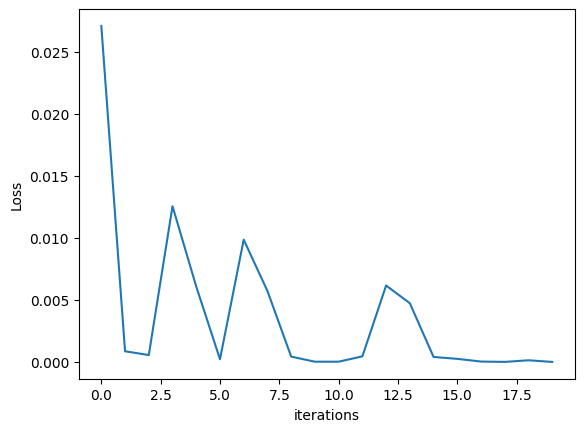

In [47]:
# Plot the epoch vs loss 
import matplotlib.pyplot as plt

plt.plot(list(range(num_epochs)), loss_arr)
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.show()

In [48]:
# Testing resulted model by measuring the accuracy
# accuracy = num of correction / num of total prediction

correct = 0
total = 0
for idx, test_data in enumerate(test_loader):
    x, actual = test_data
    predict = model_mnist(x)
    actual = label_conversion_for_outputlayer(actual)
    val_predict, indices_predict = torch.max(predict, 0)
    val_actual, indices_actual = torch.max(actual, 0)
    if indices_predict == indices_actual:
        correct += 1
    total += 1
print("number of correction=", correct, " out of ", total, ", accuracy=", correct/total)


number of correction= 9344  out of  10000 , accuracy= 0.9344


img/0.jpg , predicted number= 0
img/1.jpg , predicted number= 1
img/2.jpg , predicted number= 8
img/3.jpg , predicted number= 3
img/4.jpg , predicted number= 4
img/5.jpg , predicted number= 0
img/6.jpg , predicted number= 6
img/7.jpg , predicted number= 7
img/8.jpg , predicted number= 8
img/9.jpg , predicted number= 7


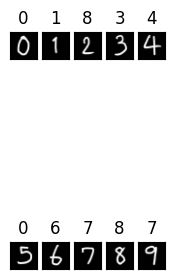

In [49]:
# Test with your own handwritten images.
import cv2
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(2, 5))
for i in range(1, 11):
    # Load image, Resize to 28x28, Invert and Normalize the pixel values
    path = 'img/' + str(i-1) + '.jpg'
    img_original = cv2.imread(path)
    img = cv2.resize(img_original, (28, 28), interpolation=cv2.INTER_AREA)
    img = cv2.bitwise_not(img)
    img = img / 256
    ax = fig.add_subplot(2, 5, i)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(img)
    
    # Convert numpy image into tensor image
    # Select only 1 channel of RGB images is enough.
    # Add dimension to image to have the same format as MNIST data which has 4 dimensions with unsqueeze()
    img = torch.Tensor(img[:,:,0])
    img = img.unsqueeze(0).unsqueeze(0)
    
    # Prediction
    predict = model_mnist.forward(img)
    val_predict, indices_predict = torch.max(predict, 0)
    print(path, ", predicted number=", int(indices_predict))
    plt.title(str(int(indices_predict)))


In [50]:
# Save the model in PyTorch .pth file with its current state
import torch
path = 'model_mnist.pth'
torch.save(model_mnist, path)

In [51]:
# Export ONNX formatted model from .pth model 
import torch

path = 'model_mnist.pth'
loaded_model = torch.load(path, weights_only=False)
loaded_model.eval()

# input_size = 28*28
dummy_input = torch.rand(1, 28, 28)
input_names = ["input"]
output_names = ["output"]
torch.onnx.export(loaded_model,
                 dummy_input,
                 "model_mnist.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )